In [1]:
#k medio vs p_mob (solo per controllare non ci siano stranezze)

#stessi grafici ma con k medio per ogni p_mob (di base dovrebbe essere 4 ) e coloro p_mob 

#fare due scale free simmetriche con metà dei run (50) !nuovo file SIRS.py
#una con inizializzazione simmetrica e una con solo una delle due (5 e 3+2)

#e rifare tutto

In [71]:
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
from IPython.display import display, clear_output
from scipy import signal
from scipy import fftpack
from numpy.fft import fft, fftfreq
import os
import pandas as pd
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 10})

# import custom module
import SIRS


from itertools import *
from operator import *

%matplotlib inline

# Probability of extinction and extinction time

In [72]:
def extinction(I):
    
    time_first_ext = []
    time_ext = []
    
    possible_ext_time = np.argwhere(I==0.)
    
    for key, group in groupby(enumerate(possible_ext_time), lambda x: x[0] - x[1]): 
        group = list(map(itemgetter(1), group)) 
        
        time_first_ext.append(group[0]) #first ext time
        time_ext.append(len(group))    #time of extinction
        
    return time_first_ext, time_ext

In [80]:
#epidemics parameters
beta = 0.075
mu = 0.15
gamma = 0.016

directory_name = "data/"+str(beta)+"_"+str(mu)+"_"+str(gamma)

p_mob_list = np.linspace(0.03,0.2,20)[0:19]

n_runs = 100
n_iter = 1000

#window_list = [40,50,70,85,100, 150,200]

In [81]:
#for window in window_list:

ext_er=[] #will give me probability of extincion
ext_sf=[] #will give me probability of extincion
error_t_ext_er = []
error_t_ext_sf = []
t_ext_sum_er = []
t_ext_sum_sf = []
t_ext_std_er = []
t_ext_std_sf = []

mean_dg_er = []
mean_dg_sf = []
std_dg_er = []
std_dg_sf = []

for p_mob in p_mob_list:

    p_mob_dn = "/pmob_"+"{:3f}".format(p_mob)

    #print(directory_name+p_mob_dn)

    prob_ext_er = 0
    prob_ext_sf = 0
    t_ext_list_er = []
    t_ext_list_sf = []
    t_er = []
    t_sf = []
    
    list_dg_er = []
    list_dg_sf = []

    

    for run in range(n_runs):
        
        #degrees of the travelling nodes
        filename_er = directory_name+p_mob_dn+"/deg_trav_er_"+str(run)+".txt"
        filename_sf = directory_name+p_mob_dn+"/deg_trav_sf_"+str(run)+".txt"
        
        dg_er = np.loadtxt(filename_er)
        dg_sf = np.loadtxt(filename_sf)
        
        #print(dg_er)
        
        #appends mean dg for a single run (mean on number of travellers)
        list_dg_er.append(np.mean(dg_er))
        list_dg_sf.append(np.mean(dg_sf))
        
        
        #extinction and time of extinction
        filename_er = directory_name+p_mob_dn+"/SIR_er_"+str(run)+".txt"
        filename_sf = directory_name+p_mob_dn+"/SIR_sf_"+str(run)+".txt"

        SIR_er = np.loadtxt(filename_er)
        SIR_sf = np.loadtxt(filename_sf)
                
        _ , time_ext_er = extinction(SIR_er[:,1])
        _ , time_ext_sf = extinction(SIR_sf[:,1])
        
            
        e_er = len(time_ext_er) > 1 #asymmetry in initialization
        e_sf = np.any(SIR_sf[:,1] == 0)
        
        prob_ext_er += int(e_er)
        prob_ext_sf += int(e_sf)

        t_er.append(sum(time_ext_er)/n_iter)
        t_sf.append(sum(time_ext_sf)/n_iter)
        
        t_ext_list_er+=time_ext_er
        t_ext_list_sf+=time_ext_sf
        
    #computing mean degree for a single run and its std deviation (i.e. dg vs p mob)
    list_dg_er = np.array(list_dg_er)
    list_dg_sf = np.array(list_dg_sf)
    mean_dg_er.append(np.mean(list_dg_er))
    mean_dg_sf.append(np.mean(list_dg_sf))
    std_dg_er.append(np.std(list_dg_er)/np.sqrt(n_runs))
    std_dg_sf.append(np.std(list_dg_sf)/np.sqrt(n_runs))
      
    #computing comulative time of extinction    
    t_er = np.array(t_er)
    t_sf = np.array(t_sf)
    t_ext_sum_er.append(np.mean(t_er))
    t_ext_sum_sf.append(np.mean(t_sf)) 
    t_ext_std_er.append(np.std(t_er)/np.sqrt(n_runs))
    t_ext_std_sf.append(np.std(t_sf)/np.sqrt(n_runs))

    ext_er.append(prob_ext_er/n_runs)
    ext_sf.append(prob_ext_sf/n_runs)
    
    #print(prob_ext_er/n_runs)
    
    '''fig, ax = plt.subplots(1,2, figsize=(15,8))
    ax[0].hist(t_ext_list_er)
    ax[0].set_title("ER network - N=%d"%len(t_ext_list_er))
    ax[1].hist(t_ext_list_sf)
    ax[1].set_title("SF network - N=%d"%len(t_ext_list_sf))
    plt.show()'''
        
        
#error on probability of extinction computed as binomial process        
ext_er=np.array(ext_er)       
ext_sf=np.array(ext_sf)       
error_t_ext_er  = np.sqrt(ext_er*(1-ext_er))/np.sqrt(n_runs)
error_t_ext_sf  = np.sqrt(ext_sf*(1-ext_sf))/np.sqrt(n_runs)




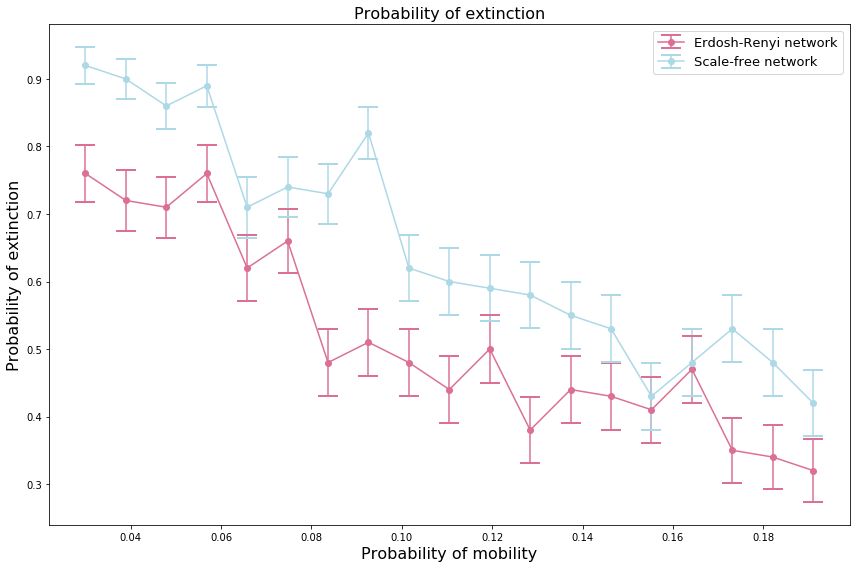

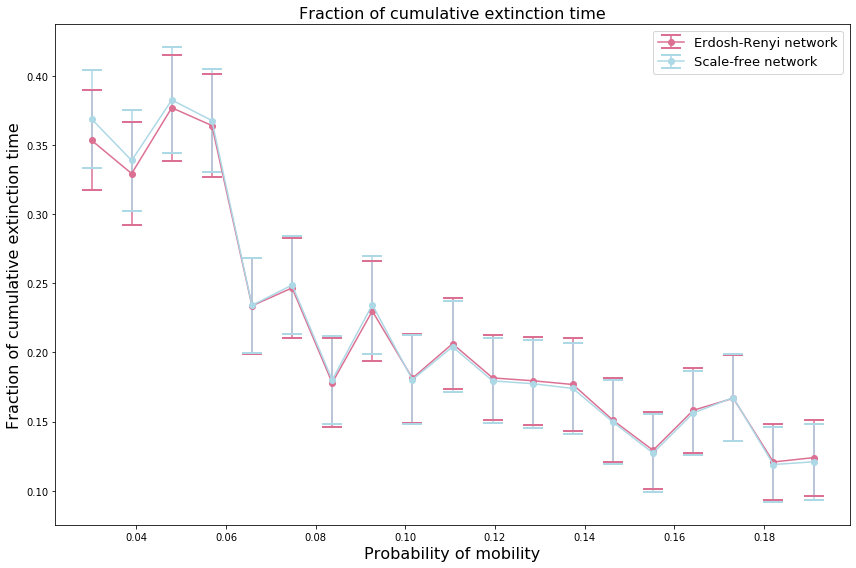

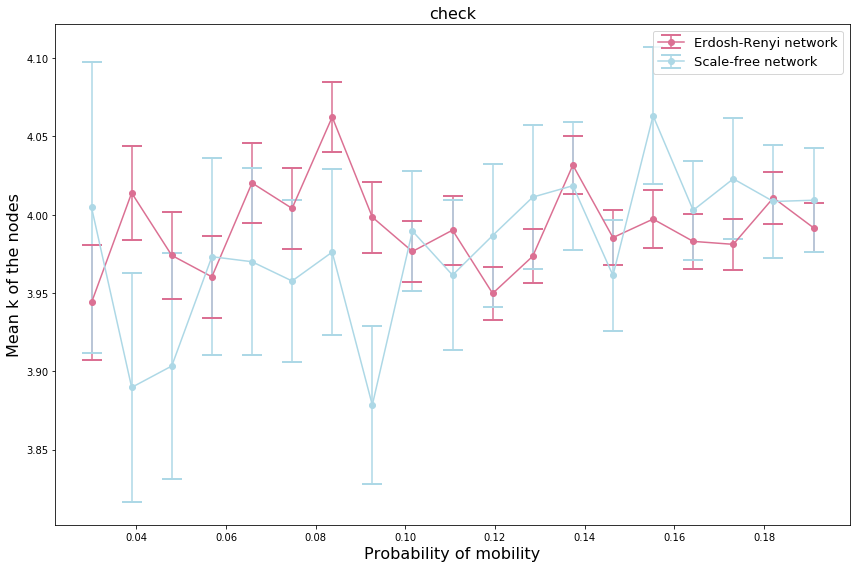

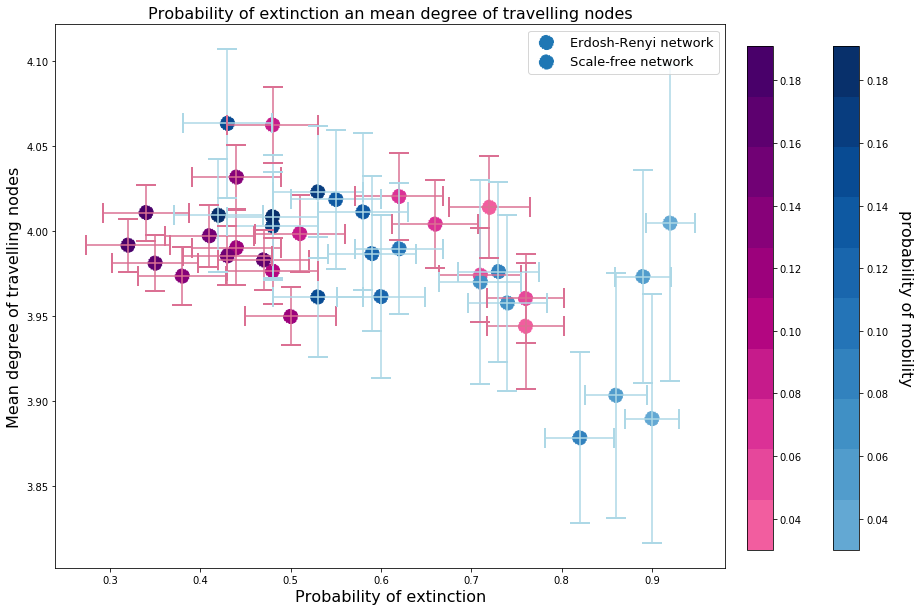

In [88]:

#plot prob of extinction
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.errorbar(p_mob_list, ext_er, error_t_ext_er, fmt="-o", marker="o", capthick=2, 
                                                       color="palevioletred", label="Erdosh-Renyi network")
ax.errorbar(p_mob_list, ext_sf, error_t_ext_sf, fmt="-o", marker="o", capthick=2, 
                                                       color="lightblue", label="Scale-free network")
ax.set_title("Probability of extinction", fontsize=16)
ax.set_xlabel("Probability of mobility", fontsize=16)
ax.set_ylabel("Probability of extinction", fontsize=16)
ax.legend(fontsize=13, loc='upper right')
fig.tight_layout()
title = directory_name+"/p_extinction.png"
fig.savefig(title)


#plot cumulative extinction time
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.errorbar(p_mob_list, t_ext_sum_er, t_ext_std_er, fmt="-o", marker="o", capthick=2,  
                                                       color="palevioletred", label="Erdosh-Renyi network")
ax.errorbar(p_mob_list, t_ext_sum_sf, t_ext_std_sf, fmt="-o", marker="o", capthick=2, 
                                                       color="lightblue", label="Scale-free network")
ax.set_title("Fraction of cumulative extinction time", fontsize=16)
ax.set_xlabel("Probability of mobility", fontsize=16)
ax.set_ylabel("Fraction of cumulative extinction time", fontsize=16)
ax.legend(fontsize=13, loc='upper right')

fig.tight_layout()
title = directory_name+"/p_t_extinction.png"
fig.savefig(title)

#plot mean k vs p_mob
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.errorbar(p_mob_list, mean_dg_er, std_dg_er, fmt="-o", marker="o", capthick=2,  
                                                       color="palevioletred", label="Erdosh-Renyi network")
ax.errorbar(p_mob_list, mean_dg_sf, std_dg_sf, fmt="-o", marker="o", capthick=2, 
                                                       color="lightblue", label="Scale-free network")
ax.set_title("check", fontsize=16)
ax.set_xlabel("Probability of mobility", fontsize=16)
ax.set_ylabel("Mean k of the nodes", fontsize=16)
ax.legend(fontsize=13, loc='upper right')

fig.tight_layout()
plt.show()




#plot probability of extinction vs mean degree of travelling nodes
import matplotlib as mpl

cmapB = mpl.cm.Blues(np.linspace(0,1,20))
cmapB = mpl.colors.ListedColormap(cmapB[10:,:-1])

cmapP = mpl.cm.RdPu(np.linspace(0,1,20))
cmapP = mpl.colors.ListedColormap(cmapP[10:,:-1])


fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.errorbar( ext_er, mean_dg_er,xerr = error_t_ext_er, yerr=std_dg_er, ls = "None", color="palevioletred", capthick=2)
im1 = ax.scatter(ext_er,mean_dg_er,   ls = "-.", s=200,c=p_mob_list, cmap=cmapP, label="Erdosh-Renyi network")                                                  
#fig.colorbar(im1, ax=ax)
cbaxes = fig.add_axes([0.925, 0.15, 0.03, 0.7]) 
cb = plt.colorbar(im1, cax = cbaxes) 
ax.errorbar(ext_sf, mean_dg_sf, yerr = std_dg_sf, xerr=error_t_ext_sf, ls = "None", color="lightblue", capthick=2)
im2 = ax.scatter( ext_sf, mean_dg_sf,  ls = "-.", s=200, c=p_mob_list, cmap=cmapB, label="Scale-free network")
cbaxes = fig.add_axes([1.025, 0.15, 0.03, 0.7]) 
cb = plt.colorbar(im2, cax = cbaxes)
cb.ax.set_ylabel('probability of mobility', rotation=270, fontsize=16, labelpad=25)
#fig.subplots_adjust(wspace=0.05, hspace=0.4, right=0.8)
ax.set_title("Probability of extinction an mean degree of travelling nodes", fontsize=16)
ax.set_ylabel("Mean degree of travelling nodes", fontsize=16)
ax.set_xlabel("Probability of extinction", fontsize=16)
ax.legend(fontsize=13, loc='upper right')
#fig.tight_layout()
title = directory_name+"/p_extinction_dg.png"
#fig.savefig(title)

# DEBUG: 


CHECKING IF NUMBER OF TRAVELLING NODES IS CHANGED CORRECTLY 

Do this by counting the number of travelling nodes at each iteration and run: number of travelling nodes must be consistent at each run in same p_mob but must be different for each p_mob

In [ ]:
#epidemics parameters
beta = 0.075
mu = 0.15
gamma = 0.016

directory_name = str(beta)+"_"+str(mu)+"_"+str(gamma)

p_mob_list = np.linspace(0.03,0.2,20)[0:18]

n_runs = 30


travelling_er_old = 0
travelling_sf_old = 0

for p_mob in p_mob_list:

    p_mob_dn = "/pmob_"+"{:3f}".format(p_mob)
    
    filename_er = directory_name+p_mob_dn+"/travellers_er_0.txt"
    filename_sf = directory_name+p_mob_dn+"/travellers_sf_0.txt"
        
    travelling_er_new = len(np.loadtxt(filename_er))
    travelling_sf_new = len(np.loadtxt(filename_sf))


    
    #check 0.a
    if travelling_er_new == travelling_er_old: 
        print("Check 0.a failed for p_mob",p_mob)
        break
    #check 0.b
    if travelling_sf_new == travelling_sf_old: 
        print("Check 0.b failed for p_mob", p_mob)
        break
        
    #print("Travelling er:", travelling_er_new)
    #print("Travelling sf:", travelling_sf_new)
    
    for run in range(n_runs):

        filename_er = directory_name+p_mob_dn+"/travellers_er_"+str(run)+".txt"
        filename_sf = directory_name+p_mob_dn+"/travellers_sf_"+str(run)+".txt"
        
        travelling_er = len(np.loadtxt(filename_er))
        travelling_sf = len(np.loadtxt(filename_sf))
        
        #check1
        if travelling_er != travelling_sf : 
            print("Check_1 failed for run {} and p_mob {}".format(run, p_mob))
            break
        #check_2.a
        if travelling_er != travelling_er_new : 
            print("Check 2.a failed for run {} and p_mob {}".format(run, p_mob))
            break
        #check_2.b
        if travelling_sf != travelling_sf_new : 
            print("Check 2.b failed for run {} and p_mob {}".format(run, p_mob))
            break
      
    travelling_er_old = travelling_er_new
    travelling_sf_old = travelling_er_new
            

In [5]:
0*10

0

In [6]:
[0]*10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]